In [1]:
import torch
import torch.nn as nn
import numpy as np


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    """ResNet BasicBlock"""
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)

        return out


class Patch_2D_Model(nn.Module):
    """Patch2D Refine Model, used while stacking patch on channel"""
    def __init__(self, output_shape: list, activation=nn.ReLU):
        super(Patch_2D_Model, self).__init__()
        self.out = output_shape
        self.inplanes = 64
        self.conv1 = nn.Conv2d(output_shape[0], 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        if activation.__name__ == 'ReLU':
            self.relu = activation(inplace=True)
        else:
            self.relu = activation()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            *[nn.Linear(128, 256, bias=False), nn.BatchNorm1d(256), nn.ReLU(inplace=True), nn.Dropout(0.2),
              nn.Linear(256, 256, bias=False), nn.BatchNorm1d(256), nn.ReLU(inplace=True), nn.Dropout(0.2),
              nn.Linear(256, np.prod(self.out), bias=True)])

        # Initialize weight
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                nn.BatchNorm2d(planes),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      print(f"After maxpool: {x.shape}")  # Debugging print

      x = self.layer1(x)
      print(f"After layer1: {x.shape}")  # Debugging print

      x = self.layer2(x)
      print(f"After layer2: {x.shape}")  # Debugging print

      x = self.avgpool(x)
      print(f"After avgpool: {x.shape}")  # Debugging print

      x = x.view(-1, self.inplanes)
      print(f"After view: {x.shape}")  # Debugging print

      x = self.fc(x)
      x = x.view(-1, self.out[0], self.out[1])

      return x

In [2]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=a27e045dfcde0e07880a2f58481b4e9e59374b68f1324c6e540b313dd8e3ad88
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
#import torchviz
# Instantiate the model
#model = Patch_2D_Model()

# Generate a random input tensor with the shape [batch_size, channels, height, width]
#input_tensor = torch.rand(1, 15, 64, 64)

# Visualize the model
#graph = torchviz.make_dot(model(input_tensor), params=dict(model.named_parameters()))
#graph.view()

TypeError: Patch_2D_Model.__init__() missing 1 required positional argument: 'output_shape'

In [5]:
# Specify the output shape
output_shape = [15,2]

# Create the model instance
model = Patch_2D_Model(output_shape)

# Load the weights from the file, mapping storage to the CPU
checkpoint = torch.load('mod_A.pth', map_location=torch.device('cpu'))

# If the model was trained using DataParallel, the state_dict keys will have 'module.' prefix
state_dict = checkpoint['state_dict']
new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace('module.', '')  # remove 'module.' prefix
    new_state_dict[name] = v

# Load the weights into the model
model.load_state_dict(new_state_dict)

# Set the model to evaluation mode if you are going to use it for inference
#model.eval()

# You can now use the model for inference or further training


<ipython-input-5-3921a71634ff>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('mod_A.pth', map_location=torch.device('cpu'))


<All keys matched successfully>

In [7]:

print(model)


Patch_2D_Model(
  (conv1): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_s

In [10]:
import torch

# Set the model to evaluation mode
model.eval()

# Define the input shape (batch_size, channels, height, width)
batch_size = 1
channels = 15
height = 40  # Example height, adjust if needed
width = 40   # Example width, adjust if needed

# Create a dummy input tensor with the specified shape
dummy_input = torch.randn(batch_size, channels, height, width)
print(f"Input shape: {dummy_input.shape}")


# Pass the dummy input through the model
output = model(dummy_input)

# Print the output shape
print(f"Output shape: {output.shape}")
print(f"Output: {output}")


Input shape: torch.Size([1, 15, 40, 40])
After maxpool: torch.Size([1, 64, 10, 10])
After layer1: torch.Size([1, 64, 10, 10])
After layer2: torch.Size([1, 128, 5, 5])
After avgpool: torch.Size([1, 128, 1, 1])
After view: torch.Size([1, 128])
Output shape: torch.Size([1, 15, 2])
Output: tensor([[[ -6.8012,  -4.7019],
         [-12.9163,  -3.1426],
         [-24.5664,  -4.4744],
         [ 10.3651, -10.4614],
         [-24.7908,   7.2981],
         [ 13.1514,  -9.9907],
         [-35.0759,  23.3596],
         [  8.0823, -20.4642],
         [ -7.4398,  -4.2303],
         [-14.5916,  -2.0935],
         [  0.7380,  -4.2571],
         [-10.7375,  -5.0306],
         [  5.9100,   1.2948],
         [-17.9230,   6.5739],
         [ 12.8849,  -3.1703]]], grad_fn=<ViewBackward0>)


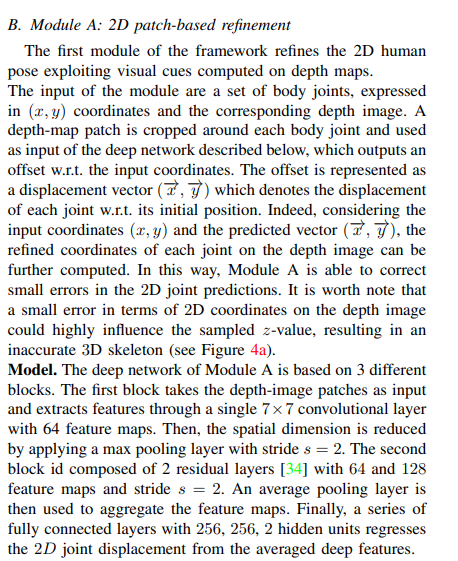
